In [1]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import scipy.stats as sps
np.random.seed(1234)


In [2]:
N = 1000
n = 5
t0 = 0.
T = 21.
n_obs = 40


dt = 0.01  # pas de discrétisation pour euler explicite
x0 = np.array([0, 0, 0, 2, 0])

##############################
# perturbation observation
sigma_obs = 0.1
# perturbation évolution
sigma_evo = 0.1
##############################

In [3]:
t_obs = np.linspace(0.5, T, n_obs)  # dates auxquelles on observe

def f_traj(t, x):
    v = 2.0
    w = np.sin(t)
    return np.array([v*np.cos(x[2]), v*np.sin(x[2]), w])


# simulation d'une trajectoire continue à haute précision, que l'on considère exacte.
sol_traj = solve_ivp(fun=f_traj, t_span=[
                     t0, T], y0=x0[:3], dense_output=True, t_eval=np.arange(t0, T, dt), rtol=1e-4)


def y_traj(t):
    # on sélectionne les deux premières composantes de la solution "exacte" au temps t : mesure de position exacte
    return sol_traj.sol(t)[:2]


# observations Y
y_obs = y_traj(t_obs)  # shape=(2,n_obs)
# génération des n_obs vecteurs de bruit d'observation associés aux y_t effectivement observés
list_epsi_obs = np.random.normal(0, scale=sigma_obs, size=(n_obs, 2))
y_obs = y_obs + np.transpose(list_epsi_obs)

In [4]:
def f_ext(t, x):
    return np.array([x[3]*np.cos(x[2]), x[3]*np.sin(x[2]), x[4], 0, 0])


# euler explicit
def solve_euler_explicit(f, x0, dt, t0, tf):
    ts, xs = [t0], [x0]
    while ts[-1] < tf:
        t, x = ts[-1], xs[-1]
        t_next, x_next = t + dt, x + dt * f(t, x)
        ts.append(t_next)
        xs.append(x_next)
    return (np.array(ts), np.array(xs))


def predict_euler_explicit(f, x0, dt, t0, tf):
    t, x = t0, x0
    while t < tf:
        t_next, x_next = t + dt, x + dt * f(t, x)
        print(type(t_next), type(x_next), type(tf))
        t = t_next
        x = x_next
    return x


def gaussian_density_1D(v, m, sig):
    """return the evaluation in v of the density function of a random variable following a 1D gaussian law N(m,sig)"""
    return 1/(np.sqrt(2*np.pi)*sig)*np.exp(-0.5*((v-m)/sig)**2)


def dens_obs(obs, pos):
    """return evaluation in obs (2D vec) of density of Y_t knowing X_t[:2]=pos (2D vec)
    not caracterized by noise epsi on observation of x_t """
    return gaussian_density_1D(obs[0], pos[0], sigma_obs) * gaussian_density_1D(obs[1], pos[1], sigma_obs)


def q(epsi):
    """return evaluation in x_t of instrumental density of X_t knowing X_t_1 = x_t-1 
    caracterized by noise epsi on acceleration of x_t-1"""
    return gaussian_density_1D(epsi[0], 0, sigma_evo) * gaussian_density_1D(epsi[1], 0, sigma_evo)


def calc_w(k, x_k, list_epsi_evo):
    """returns non normalized weights at k-th iteration
    x_k is (N,n) and contains all particles (5D) at iteration k
    elements of list_epsi_evo are 2D vectors"""
    w_k = np.zeros((N,), dtype=np.longdouble)
    for i in range(N):
        w_k[i] = dens_obs(y_obs[:, k], x_k[i][:2]) / q(list_epsi_evo[i])
    return w_k  # PAS normalisation


def kalm_prob():
    """ calculate the simulated trajectory with probabilistic kalman filter
    particles are stored before resample"""

    t_obs = np.linspace(0.5, T, n_obs)  # dates auxquelles on observe


    x = [np.array([x0.copy()] * N, dtype=np.longdouble)]  # x.shape=(N,n)
    w0 = np.full((N,), 1/N)  # poids en t=0
    w = [w0.copy()]

    # calcul de x_k,w_k
    for k in range(1, n_obs):
        # rééchantillonnage des particules en k-1
        x_k_1_res = x[-1][np.random.choice(N, N, p=w[-1])]

        # génération des N vecteurs de bruit sur les accélérations associés aux particules en k-1 resampled qu'on fait évoluer
        list_epsi_evo_k = np.random.normal(0, scale=sigma_evo, size=(N, 2))
        # perturbation des accélérations des x_k-1
        x_k_1_res[:, 3:] = x_k_1_res[:, 3:] + list_epsi_evo_k

        # calcul de x_k
        x_k = np.zeros((N, n), dtype=np.longdouble)
        for i in range(N):
            # 1 itération avec euler explicite depuis les x_k-1
            x_k[i] = solve_euler_explicit(
                f_ext, x_k_1_res[i], dt, t_obs[k-1], t_obs[k])[1][-1]
        
        
        # calcul des poids
        w_k = calc_w(k, x_k, list_epsi_evo_k)
        # w.append(w_k/w_k.sum())

        if np.isnan(w_k).any() or (w_k.sum() <= 1.e-200):
            print("on sort à", k)
            break
        else:
            x.append(x_k)
            w.append(w_k/w_k.sum())

    return x, w

def spatial_quantile(x_k,perc_list=[0.025,0.975]):
    """calculates the list of particles whose coordinates are the quantiles of the percentage in the perc_lists of the 2 lists coordinates of the particles x_k"""
    qt_abscisses= np.quantile(x_k[:,0],perc_list)
    qt_ordonnees= np.quantile(x_k[:,1],perc_list)
    res=np.array([np.array([qt_abscisses[i],qt_ordonnees[i]]) for i in range(len(perc_list))])
    return res

def quantile_trajectories(nb_iter, x,w,perc_list=[0.025,0.975],resample=True):
    """return trajectories of quantiles"""
    qt_traj = np.zeros((nb_iter,len(perc_list),2)) #qt_traj[itération k, quantile 2, coordonnée 0]
    for k in range(nb_iter):
        if resample:
            x_k_indices_resampled = np.random.choice(N,N,p=w[k])
            x_k_resampled = x[k][x_k_indices_resampled]
            qt_traj[k] = spatial_quantile(x_k_resampled,perc_list)
        else:
            qt_traj[k] = spatial_quantile(x[k],perc_list)
    return qt_traj


def show_traj(nb_iter, list_traj):
    """plot trajectories with observed one
    list_traj[i] = [x,x_name,x_color] where x is a trajectory (array of shape=(nb_iter,n)) and x_name is its name and x_color its color"""
    for i in range(len(list_traj)):
        plt.plot(list_traj[i][0][:, 0], list_traj[i][0][:, 1],
                 label=list_traj[i][1], color=list_traj[i][2])

    plt.plot(y_obs[0], y_obs[1], label="Trajectoire observée", color="black")

    plt.grid(True)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title(
        f'{N} particules, {nb_iter} itérations, de {t0}s à {T}s, sigma_evo={sigma_evo}, sigma_obs={sigma_obs}')
    plt.legend()
    plt.show()


on sort à 9


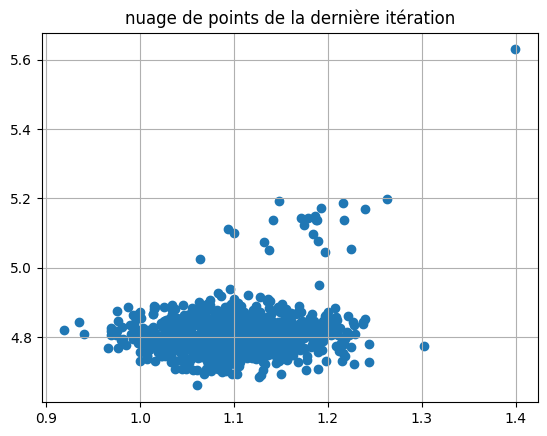

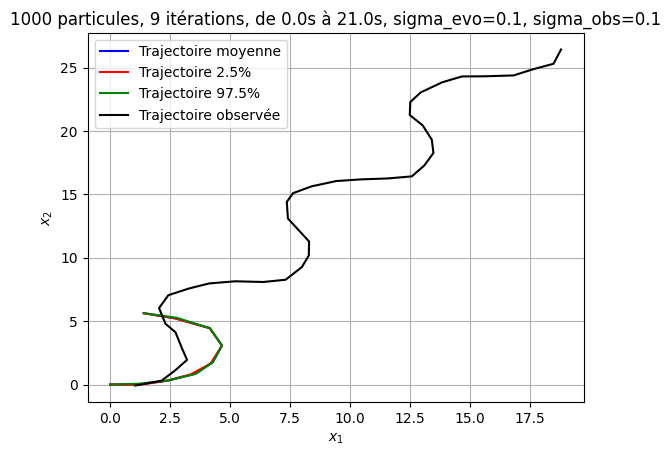

In [5]:
# # calcul nuage avec T=20s
x, w = kalm_prob()
nb_iter = len(w)  # nb d'itérations effectivement calculées

# affichage du nuage de point final
plt.scatter(x[-1][:, 0], x[-1][:, 1])
plt.grid(True)
plt.title("nuage de points de la dernière itération")
plt.show()

# calcul trajectoire moyenne
x_m = np.zeros((nb_iter, n), dtype=np.longdouble)
for k in range(nb_iter):
    x_m[k] = np.average(x[k], 0, w[k])
    
# calcul trajectoire quantiles 
qt_traj = quantile_trajectories(nb_iter,x,w,resample=True)
qt_x025=qt_traj[:,0,:]
qt_x975=qt_traj[:,1,:]
show_traj(nb_iter, [[x_m, "Trajectoire moyenne", "blue"], [
          qt_x025, "Trajectoire 2.5%", "red"], [qt_x975, "Trajectoire 97.5%", "green"]])
